# Classical Shadows

$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}
\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
Predicting properties of unkown quantum states is very useful in quantum computing. One method - quantum state tomography ([3](#ref3)) - completely reconstructs the quantum state by making many measurements of copies of the state in different bases. However, the number of copies this approach requires scales roughly with $d^2$ and $\frac{1}{\epsilon^2}$, where $d$ is the dimension of the state and $\epsilon$ is the error ($d = 2^n$, where $n$ is the number of qubits). Making this many copies of the quantum state is infeasible. 

Aaronson introduced shadow tomography ([4](#ref4)) which predicted observables simultaneously without completely reconstructing the state, which could be done using $\widetilde{O}\left(\varepsilon^{-4} \cdot \log^4 M \cdot \log d\right)$ copies of the state, where $M$ is the number of observables. However, this approach still requires a lot of quantum memory to store the copies and long circuits to make the predictions. 

Based on this idea Huang, et al. introduced classical shadow tomography ([1](#ref1)), a procedure that required only $O(\log(M))$ copies of the state, independent of the dimension of the system. The copies could also be stored efficiently in classical memory. The procedure consists of two steps: data acquisition - constructing a measurement channel from the quantum state to classical description - and prediction.

## Procedure

### Data Acquisition

One step of the data acquisition procedure consists of the following:
- Select a random unitary, $U$, transformation from a predefined, tomographically complete ensemble.
- Apply the transformation to the quantum state of interest:
$$\rho \rightarrow U\rho U^\dagger$$

- Measure the transformed quantum state in the computational basis and obtain a bit string of measurements $|b\rangle \in \{0, 1\}^n$

- Store the $\textit{snapshot}$ of the state by classically performing the reverse operation $U^\dagger |b\rangle \langle b| U$ and storing it in classical memory.

The average mapping (in terms of unitary choice and measurement result) from $\rho$ to its snapshot can be viewed as a measurement channel:
$$\mathcal{M}(\rho) = \mathbb{E}[U^\dagger |b\rangle \langle b| U]$$

'Average mapping', means that the true state is obtained from the estimated state in expectation:

$$\mathbb{E}[\hat{\rho}] = \rho$$

The measurement channel can be inverted (because the unitary ensemble is tomographically complete) to obtain the original state:
$$\rho = \mathbb{E}[\mathcal{M}^{-1}(U^\dagger |b \rangle \langle b| U)]$$

To take advantage of this, this procedure is repeated $N$ times, yielding an array of snapshots called the $\textit{classical shadow}$ of $\rho$:

$$\textbf{S}(\rho; N) = \{\hat{\rho}_1 = \mathcal{M}^{-1}(U_1^\dagger |b_1\rangle \langle b_1| U_1), ... , \hat{\rho}_N = \mathcal{M}^{-1}(U_N^\dagger |b_N\rangle \langle b_N| U_N)\}$$

### Prediction

Although the observables can be predicted using an empirical mean, the authors prefer a median-of-means approach to mitigate outliers:

- Divide the shadow into $K$ equally sized parts, and take the mean of each one to construct $K$ estimators of $\rho$

$$\hat{\rho}_{(k)} = \frac{1}{\left\lfloor N / K \right\rfloor} \sum_{i=(k-1)\left\lfloor N / K \right\rfloor + 1}^{k \left\lfloor N / K \right\rfloor} \hat{\rho}_i$$

- Then, for each observable (for $i =1$ to $M$), take the median of the means, where $\hat{O_i}$ is the estimation of the observable:

$$\hat{O_i}(N, K) = \text{median}\{\text{tr} (O_i \hat{p}_1), ..., \text{tr} (O_i \hat{p}_K)\}$$

To demonstrate the classical shadows procedure, we will build a classical shadow, fully reconstruct a state, and predict an observable.

The Classical Shadows Procedure ([1](#ref1)):

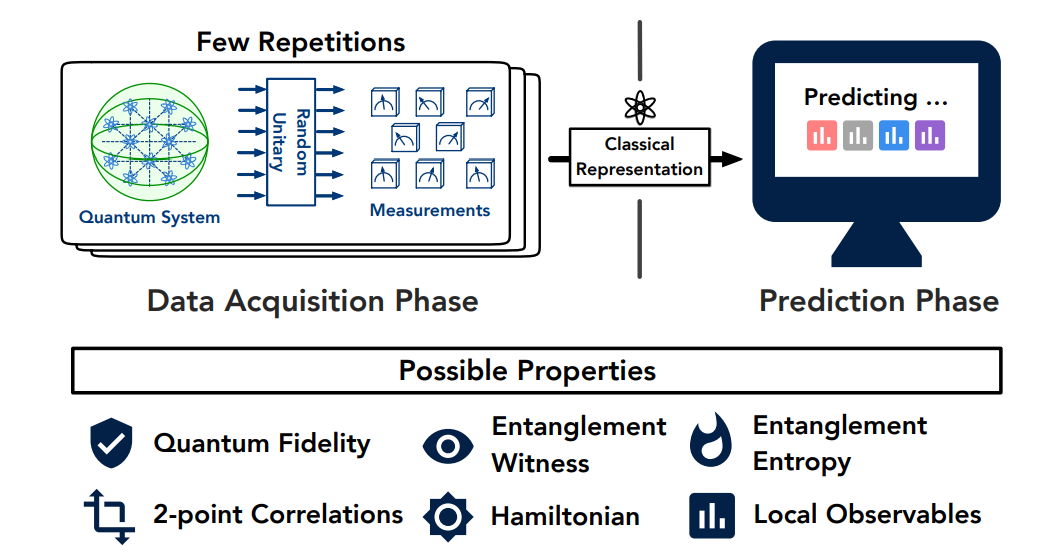

## Building a Classical Shadow

In this example, we will construct a classical shadow of the $\Phi^-$ bell state.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import *

In [2]:
np.random.seed(552)
# Global Variables: must be initialized globally because they cannot be passed quantum functions.
ids = []  # IDs of unitaries that were applied in the procedure.
num_qubits = 2

In the `main()` function, we first prepare the $\Phi^-$ bell state, then, the `unitary_application()` function applies unitaries randomly. Because it is simpler to apply single qubit gates, we will define a unitary ensemble of such gates. We choose the tomographically complete set of single qubit pauli operations {$H$, $HS$, and $I$} equivalent to measurements in the $X$, $Y$, and $Z$ bases respectively. Even though the procedure calls for applying a unitary on the whole state ($U \rho U^\dagger$), we still adhere to the procedure, because two single qubit gates can be viewed as a unitary on the whole state. For example, $H$ on the first qubit and $I$ on the second qubit is $H \otimes I$. In fact, this will prove to be convenient later.

A unitary ensemble of tensor products of single-qubit Clifford circuits (like ours) is the special case discussed in [Huang et al.](#ref1). It is easy to implement on NISQ computers, performs well when estimating local observables, but scales poorly. The other case, an ensemble of random n-qubit Clifford circuits, scales well and estimates global observables efficiently, but requires many more ($n^2/log(n)$) entangling gates to implement.

In [3]:
@qfunc
def unitary_application(state: QArray) -> None:
    """
    Applies randomly selected unitaries from a unitary ensemble. Updates `ids` with the identifiers
    of the randomly selected unitaries.

    Args:
        state (QArray): state prepared earlier in `main()`, of which the classical shadow will be calculated.
    """
    # We assign values 0, 1, 2 to mean measurements in the X, Y, Z bases respectively.
    basis_ids = list(
        np.random.randint(3, size=num_qubits)
    )  # Choose 2 integers randomly out of [0, 2]
    ids.append(basis_ids)

    for i in range(num_qubits):
        if basis_ids[i] == 0:  # Measurement in the X basis
            H(state[i])
        if basis_ids[i] == 1:  # Measurement in the Y basis
            S(state[i])
            H(state[i])
        # A measurement in the computational basis is a measurement in the Z basis. No unitary application needed.

In [4]:
@qfunc
def main(qarr: Output[QArray]) -> None:
    """
    Prepares the desired state and applies the randomly selected unitaries once. Cannot be called by user.
    """
    # If you wish to create your own state, you must initialize a quantum array first:
    # allocate(num_qubits, qarr)

    prepare_bell_state(1, qarr)
    unitary_application(qarr)

Below is a circuit that can be generated by this procedure. Due to the random unitary selection, visualizations may vary.

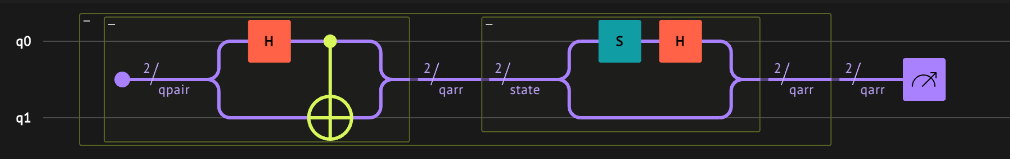

The bell state is prepared in the first part of the circuit, while the random unitaries are applied in the second part. In this case, measurements in the Y and Z bases were performed on the first and second qubits respectively.

We compute the classical shadow by executing `main()` `num_snapshots` times in `calculate_shadow()` below.

In [5]:
def calculate_shadow(num_snapshots):
    """
    Computes a shadow of size `num_snapshots` by performing `num_snapshots` measurements.

    Args:
        num_snapshots (int): Size of the shadow, also the number of measurements.

    Returns:
        snapshots (list): List of snapshots. Each snapshot is a list of measurements of every qubit in the circuit.
    """
    snapshots = []
    for i in range(num_snapshots):
        execution_preferences = ExecutionPreferences(
            num_shots=1, random_seed=np.random.randint(1e6)
        )
        qprog = synthesize(main)

        # Visualize an example circuit:
        if i == 0:
            show(qprog)

        with ExecutionSession(qprog, execution_preferences) as es:
            counts = es.sample().parsed_counts
            snapshot = list(counts[0].state["qarr"])
            snapshots.append(snapshot)

    return snapshots

In [6]:
# Collecting 200 snapshots takes ~8 minutes to run.
num_snapshots = 200
snapshots = calculate_shadow(num_snapshots)
print(f"snapshots: {snapshots}")
print(f"ids: {ids}")

Quantum program link: https://platform.classiq.io/circuit/35oY6832Hri0ScrZdjGWH4Fj8QT
snapshots: [[0, 1], [1, 0], [1, 1], [1, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 0], [1, 1], [1, 0], [0, 0], [1, 1], [1, 1], [0, 1], [0, 1], [1, 0], [1, 1], [1, 1], [0, 0], [1, 0], [1, 0], [0, 1], [1, 1], [1, 1], [1, 0], [1, 0], [0, 1], [0, 0], [0, 0], [1, 1], [0, 0], [0, 0], [1, 1], [0, 1], [0, 0], [1, 1], [0, 1], [0, 1], [0, 1], [0, 0], [0, 0], [1, 0], [0, 1], [1, 0], [1, 1], [1, 1], [1, 1], [1, 1], [0, 0], [0, 0], [1, 1], [0, 1], [0, 1], [0, 0], [1, 0], [0, 1], [1, 1], [0, 0], [0, 1], [0, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 0], [1, 1], [1, 1], [1, 1], [1, 1], [0, 1], [0, 0], [0, 1], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1], [1, 0], [0, 0], [1, 0], [1, 0], [0, 0], [0, 1], [0, 0], [1, 0], [1, 0], [0, 0], [1, 1], [1, 1], [1, 1], [0, 0], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [0, 0], [1, 1], [1, 0], [1, 1], [0, 0], [0, 1], [0, 1], [0, 0], [0, 1], [0, 0], [1, 0], [0, 1], [1, 1]

This is the end of the quantum part of the procedure - the snapshots are all we need to extract information about the state. We will now demonstrate the following uses of these snapshots:
- Full Tomography: reconstruct the state completely (not just certain pieces of information) as an instructive example. This application doesn't offer an advantage over quantum state tomography, requiring exponential resources.
- Estimating Observables: estimating the expectation values of observables by reconstructing only parts of the state. This is one of the applications where classical shadows offers an advantage.

## State Reconstruction

The two functions below perform a full state reconstruction, given enough snapshots. To reconstruct the state, we take the measurement results in `snapshots` and apply the inverse of the operations stored in `ids`. It turns out that since each of our possible unitaries is a tensor product of of randomly selected single-qubit Clifford gates, we can apply Eq. S44 from [Huang et al.](#ref1), which states that the estimated state in that case is
$$
\begin{equation}
\tag{S44}
\hat{\rho} = \bigotimes_{j=1}^{n} ( 3 U_j^\dagger |b_j\rangle \langle b_j| U_j - \mathbb{I})
\end{equation}
$$

In `snapshot_reconstruction()` below, we apply this equation to get the density matrix of the reconstructed state. `reconstruction()` averages these density matrices to get an accurate estimation of the initial state $\rho$.

In [7]:
def snapshot_reconstruction(snapshot, snapshot_ids):
    """
    Reconstructs the state density matrix from one snapshot. Helper for `reconstruction()`.

    Args:
        snapshot (list[int]): Element of snapshots; `num_qubits` long.
        snapshot_ids (list[int]): Element of `ids`.

    Returns:
        final_state (np.ndarray): Snapshot density matrix reconstruction.

    """
    # Density matrices of computational basis states
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])

    # S, H, I matrices
    S_matrix = np.array([[1, 0], [0, 1j]], dtype=complex)
    H_matrix = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
    I_matrix = np.array([[1, 0], [0, 1]])

    # Unitaries applied in circuit.
    unitaries = [H_matrix, H_matrix @ S_matrix, I_matrix]

    final_state = [1]
    for i in range(num_qubits):
        state = zero_state if snapshot[i] == 0 else one_state
        U = unitaries[int(snapshot_ids[i])]

        # Applying Eq. (S44) from Huang, et al.
        local_state = 3 * (U.conjugate().transpose() @ state @ U) - I_matrix
        final_state = np.kron(final_state, local_state)

    return final_state

In [8]:
def reconstruction(in_snapshots, in_ids):
    """
    Performs a full reconstruction of the quantum state density matrix, where the quantum state is that
    prepared in `prep_state()`.

    Args:
        in_snapshots (list): List of snapshots, which is the global `snapshots` (list of ints in {0, 1}).
        in_ids (list): List of unitary identifiers, which is the global `ids` (list of ints in {0, 1, 2}).

    Returns:
        reconstructed_state (np.ndarray): Full state density matrix reconstruction (2d numpy complex array).
    """
    # Average over snapshots.
    reconstructed_state = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)
    for i in range(num_snapshots):
        result = snapshot_reconstruction(in_snapshots[i], in_ids[i])
        reconstructed_state += result

    return reconstructed_state / num_snapshots

In [9]:
reconstructed_state = reconstruction(snapshots, ids)
print(f"Full state density matrix: \n {np.round(reconstructed_state, decimals=6)}")

bell_state_density_matrix = np.array(
    [[0.5, 0, 0, -0.5], [0, 0, 0, 0], [0, 0, 0, 0], [-0.5, 0, 0, 0.5]]
)
print(f"Bell State Density Matrix: \n {bell_state_density_matrix}")

Full state density matrix: 
 [[ 0.4075+0.j     -0.0525+0.0675j  0.0375+0.0075j -0.495 +0.j    ]
 [-0.0525-0.0675j  0.0475+0.j      0.0225-0.0675j  0.06  -0.015j ]
 [ 0.0375-0.0075j  0.0225+0.0675j  0.07  +0.j     -0.0525-0.045j ]
 [-0.495 -0.j      0.06  +0.015j  -0.0525+0.045j   0.475 +0.j    ]]
Bell State Density Matrix: 
 [[ 0.5  0.   0.  -0.5]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-0.5  0.   0.   0.5]]


With 200 snapshots the output density matrix looks similar to the $\Phi^-$ bell state density matrix. To quantitatively compare the reconstructed state to the true state, we will use the cell below to compute the 'distance' (the Frobenius norm) between the two states.

In [10]:
print(f"Comparing to: \n {bell_state_density_matrix}")
# distance = norm(ref_state_density_matrix, reconstructed_state)
difference = bell_state_density_matrix - reconstructed_state
distance = np.linalg.norm(difference, "fro")
print(f"Distance: {np.round(distance, decimals=6)}")

Comparing to: 
 [[ 0.5  0.   0.  -0.5]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-0.5  0.   0.   0.5]]
Distance: 0.247538


The accuracy of the reconstruction increases with the number of snapshots. Test different values for `num_snapshots` to see for yourself. The execution time scales linearly with the number of snapshots.

Although completely reconstructing a state using the classical shadows procedure is an instructive example, the procedure doesn't offer much advantage when doing so. Classical shadows shine when estimating many observables.

## Estimating Observables

In this example, we will assume that our observables are only made up of Pauli $I, X, Y, Z$ operators. That is, $O = \bigotimes_j^n \sigma_j$, where $n$ is the number of qubits. Recall that to estimate an observable, we compute the median of observable estimators. Each estimator is the product of the observable and the mean of the estimated states in the median-of-means division:

$$\hat{\rho}_{(k)} = \frac{1}{\left\lfloor N / K \right\rfloor} \sum_{i=(k-1)\left\lfloor N / K \right\rfloor + 1}^{k \left\lfloor N / K \right\rfloor} \hat{\rho}_i$$

$$\hat{O}(N, K) = \text{median}\{\text{tr} (O \hat{p}_1), ..., \text{tr} (O \hat{p}_K)\}$$

For each of $\text{tr} (O \hat{p}_i)$, we must compute the estimated states from the snapshots in the shadow. For this, we will apply Eq. S44 from [Huang et al.](#ref1), as we did above:
$$\text{tr}(O \hat{p}_i) = \text{tr}\{\bigotimes_{n=1}^{j} \sigma_j (3 U_j^\dagger |\hat{b_j}\rangle \langle \hat{b_j}| U_j - \mathbb{I})\}$$
$$=\prod_{j=1}^{n} \ \text{tr} \sigma_J \{(3 U_j^\dagger |\hat{b_j}\rangle \langle \hat{b_j}| U_j) - \mathbb{I}\}$$

When the basis matches the observable, e.g. $\sigma_j = X$, and we measured in the $X$ basis (applied $H$ in the circuit), the trace evaluates to $3$ when $|\hat{b_j}\rangle = |0\rangle$ and $-3$ when $|\hat{b_j}\rangle = |1\rangle$. If $\sigma_j = I$, the trace evaluates to $1$. Otherwise, the trace evaluates to $0$, making the product $0$.

In [11]:
def estimate_observable(in_snapshots, in_ids, observable, div):
    """
    Estimates the expectation value of an observable using a classical shadow.

    Args:
        in_snapshots (list[int]): List of snapshots, which is the global `snapshots`.
        in_ids (list[int]): List of unitary identifiers, which is the global `ids`.
        observable (SparsePauliOp): Observable to be estimated.
        div (int): Number of divisions for median-of-means.

    Returns:
        expval (float): Esimated expectation value.
    """
    sum = 0
    in_snapshots = np.array(in_snapshots)
    in_ids = np.array(in_ids)

    # Loop takes care of observables that are sums.
    for element in observable.terms:
        means = []
        ops = []  # operators in observable

        # Pauli.I = 0, Pauli.X = 1, Pauli.Y = 2, Pauli.Z = 3
        for i in range(num_qubits):
            if i < len(element.paulis):
                ops.append(
                    element.paulis[i].pauli - 1
                )  # Subtracting 1 to stay consistent with format of ids, where X, Y, Z correspond to 0, 1, 2.
            else:
                ops.append(-1)  # Add I operator if no operator present.

        ops = np.array(ops)

        for i in range(0, num_snapshots, num_snapshots // div):
            # Divide in_snapshots and in_ids into div chunks.
            in_snapshots_div, in_ids_div = (
                in_snapshots[i : i + num_snapshots // div],
                in_ids[i : i + num_snapshots // div],
            )

            prods = []
            for j in range(num_snapshots // div):
                # Terms that will be in the product.
                terms = np.ones_like(ops)

                # Create masks for identity, matching, and non-matching operators.
                non_id_mask = ops != -1
                match_mask = ops == in_ids_div[j]
                mismatch_mask = (~match_mask) & non_id_mask

                # Handle matches.
                terms[match_mask & (in_snapshots_div[j] == 0)] = 3.0
                terms[match_mask & (in_snapshots_div[j] == 1)] = -3.0

                # Handle mismatches.
                terms[mismatch_mask] = 0.0
                prods.append(np.prod(terms))

            means.append(np.mean(prods))
        sum += np.median(means) * element.coefficient
    return sum

In this example, we will estimate the expectation value of the observable $Z \otimes Z$. Due to the low number of snapshots (as we will see in the next section), the estimation may not be very accurate, and will vary with different sets of snapshots.

In [12]:
observable = Pauli.Z(0) * Pauli.Z(1)
print(
    f"Estimated expectation value: {estimate_observable(snapshots, ids, observable, div=10)}"
)

Estimated expectation value: 0.9


To check that this matches the ground truth, we use Classiq's `ExecutionSession`.

In [13]:
# Since this function has the same name as the quantum function we used to generate the snapshots,
# the previous main() will need to be rerun in order to generate snapshots again.


@qfunc
def main(qarr: Output[QArray]) -> None:
    prepare_bell_state(1, qarr)

In [14]:
qprog2 = synthesize(main)
execution_preferences = ExecutionPreferences(
    num_shots=1, random_seed=np.random.randint(1e6)
)
es = ExecutionSession(qprog2, execution_preferences)
eval = es.estimate(observable).value.real
print(f"Exact expectation value: {eval}")
es.close()

Exact expectation value: 1.0


To compute the number of snapshots we need to accurately predict $M$ observables with probability $1-\delta$ that the error is $\epsilon$, we use Eq. S13 from [Huang et al.](#ref1):

$$
\begin{equation}
\tag{S13}
K = 2\log(\frac{2M}{\delta}) \ and \ N = \frac{34}{\epsilon^2} \max_{1\le i \le M} \| O_i - {\frac{\text{tr} (O_i)} {2^n}} \| _{\text{shadow}}^2
\end{equation}
$$

$\| \cdot \|_{shadow}$ is the 'shadow norm' defined in Eq. S7 of [Huang et al.](#ref1). For our case of a unitary ensemble consisting of Pauli basis measurements, it is equivalent to

$$\| O_i - {\frac{\text{tr} (O_i)} {2^n}} \| _\infty^2$$

$NK$ snapshots is sufficient to accurately predict $M$ observables using the median-of-means algorithm with $K$ divisions such that

$$|\hat{o_i}(N, K) - \text{tr} (O_i \rho)| \le \epsilon \ \ \forall \ \ 1 \le i \le M \ \ \text{ with probability} \ge 1-\delta$$

The `error_bound()` function below implements this equation for the case of an ensemble consisting of Pauli basis measurements to calculate the number of snapshots required for this bound and the size of the median-of-means divisions. For other ensembles, the shadow norm ($\| O_i - {\frac{\text{tr} (O_i)} {2^n}} \| _{\infty}^2$ for our case) may be different, in which case it must be rederived from Eq. S7.

In [15]:
def error_bound(error, observables, delta):
    """
    Calculates the minimum shadow size that guarantees a given error and probability of failure for a unitary ensemble consisting of Pauli basis measurements.
    Implements Eq. 13 from Huang et al..
    Args:
        error (float): Desired error.
        observables (list[SparsePauliOp]) : List of SparsePauliOps.
        delta (float): Probability of failure.

    Returns:
        samples (tuple(int, int)): Number of samples required to satisfy the shadow bound and the number of median-of-means
        divisions required to attain the specified probability of failure `delta`.
    """

    observable_ops = [hamiltonian_to_matrix(term) for term in observables]

    M = len(observable_ops)
    K = 2 * np.log(2 * M / delta)

    shadow_norms = []
    for op in observable_ops:
        shadow_norms.append(
            np.linalg.norm(
                op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
            )
            ** 2
        )

    N = 34 * max(shadow_norms) / error**2

    return int(np.ceil(N * K)), int(K)

In [16]:
observables = [observable]
required_snapshots = error_bound(0.2, observables, 0.01)
print(
    f"Number of samples required: {required_snapshots[0]}, Number of divisions: {required_snapshots[1]}"
)

Number of samples required: 9008, Number of divisions: 10


To estimate $Z \otimes Z$ with an error of $0.2$ and a probability of failure of $0.01$, we need $9008$ snapshots with $10$ median-of-means divisions.

In summary, we have learned how to reconstruct full states and estimate observables using the classical shadows procedure on Classiq. However, the procedure can accomplish much more, such as estimating fidelity, finding entaglement witnesses, and estimating entaglement entropy, as [Huang et al.](#ref1) do.

## References

<a id='ref1'></a>
[[1]](#ref1) Huang, HY., Kueng, R. & Preskill, J. Predicting many properties of a quantum system from very few measurements. Nat. Phys. 16, 1050–1057 (2020). https://doi.org/10.1038/s41567-020-0932-7

<a id='ref2'></a>
[[2]](#ref2) Wiersema, R., & Doolittle, B. (2021, June). Classical shadows. PennyLane Demos. Xanadu. https://pennylane.ai/qml/demos/tutorial_classical_shadows

<a id='ref3'></a>
[[3]](#ref3) J. Haah, A. W. Harrow, Z. Ji, X. Wu and N. Yu, "Sample-Optimal Tomography of Quantum States," in IEEE Transactions on Information Theory, vol. 63, no. 9, pp. 5628-5641, Sept. 2017, doi: 10.1109/TIT.2017.2719044.

<a id='ref4'></a>
[[4]](#ref4) Aaronson, S. (2018). Shadow tomography of quantum states. arXiv. https://arxiv.org/abs/1711.01053